In [55]:
import pandas as pd
import numpy as np
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
import gc
from tqdm import tqdm
import time
from collections import defaultdict
import copy
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from transformers import AutoModel, AutoTokenizer
from transformers import BatchEncoding
import numpy as np
import torch
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import AllChem  # Ensure this line is included
import matplotlib.pyplot as plt
import pdb
from PIL import Image
import io

import wandb

# Defining global parameters

In [2]:
def get_available_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"
    
CONFIG = {
    "seed": 42,
    "epochs": 12, # 42, ~MAX 20 hours of training
    "train_batch_size": 16,
    "valid_batch_size": 64,
    "learning_rate": 5e-5,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 5e-7,
    "T_max": 12,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": get_available_device(),
    'labels': ['unable_to_assess', 'not_close_match','close_match', 'near_exact_match', 'exact_match'], # 'unable_to_assess', 'not_close_match','close_match', 'near_exact_match', 'exact_match'
    'FP': 'molformer', # 'fp', 'molformer', 'ECFP', 'grover'
}

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(seed=CONFIG['seed'])

# Read the data that has duplicates REMOVED
## Validation set of 20% of the size

In [3]:
train_df = pd.read_pickle('../data/train_split_remove_duplicates_all_embeddings.pkl')
valid_df = pd.read_pickle('../data/valid_split_remove_duplicates_all_embeddings.pkl')

In [4]:
if CONFIG['FP'] == 'ECFP':
    CONFIG['input_size'] = 2048
elif CONFIG['FP'] == 'molformer':
    CONFIG['input_size'] = 768
elif CONFIG['FP'] == 'fp':
    CONFIG['input_size'] = 2215
elif CONFIG['FP'] == 'grover':
    CONFIG['input_size'] = 5000


## Wrapping in Pytorch Dataset

In [5]:
class EnvedaDatasetSmileMolformer(Dataset):
    def __init__(self, dataframe, labels = ['unable_to_assess', 'close_match', 'not_close_match', 
                                            'near_exact_match', 'exact_match']):
        """
        Args:
            dataframe (pd.DataFrame): A DataFrame containing 'ground_truth_embeddings', 
                                       'predicted_embeddings', and output columns.
        """
        self.dataframe = dataframe
        
        # Convert embeddings to tensors
        self.ground_truth_embeddings = torch.tensor(dataframe['ground_truth_embeddings'].tolist(), dtype=torch.float32)
        self.predicted_embeddings = torch.tensor(dataframe['predicted_embeddings'].tolist(), dtype=torch.float32)
        
        # Get molecular smiles
        self.ground_truth_smiles = dataframe['ground_truth_smiles'].to_list()
        self.predicted_smiles = dataframe['predicted_smiles'].to_list()

        # Convert labels to tensor
        self.labels = torch.tensor(dataframe[labels].values, dtype=torch.float32)

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.dataframe)

    def __getitem__(self, idx):
        """Generates one sample of data."""
        #return self.ground_truth_embeddings[idx].squeeze(0), self.predicted_embeddings[idx].squeeze(0), self.labels[idx]
        return self.ground_truth_smiles[idx], self.predicted_smiles[idx], self.labels[idx]

In [6]:
trainset = EnvedaDatasetSmileMolformer(dataframe=train_df, labels=CONFIG['labels'])
validset = EnvedaDatasetSmileMolformer(dataframe=valid_df, labels=CONFIG['labels'])

C:\Users\86136\AppData\Local\Temp\ipykernel_54224\3388207282.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  self.ground_truth_embeddings = torch.tensor(dataframe['ground_truth_embeddings'].tolist(), dtype=torch.float32)


## Wrapping in Pytorch DataLoader

In [7]:
trainloader, validloader = DataLoader(trainset, batch_size=CONFIG['train_batch_size']), \
                           DataLoader(validset, batch_size=CONFIG['valid_batch_size'])

In [8]:
gt, pred, labels = next(iter(trainloader))
print(len(gt), len(pred), labels.shape)


16 16 torch.Size([16, 5])


# Defining neural network

In [9]:
print(torch.cuda.is_available())

False


In [10]:
molformer_embedder = AutoModel.from_pretrained("ibm/MoLFormer-XL-both-10pct", deterministic_eval=True, trust_remote_code=True).to(CONFIG['device'])
tokenizer = AutoTokenizer.from_pretrained("ibm/MoLFormer-XL-both-10pct", trust_remote_code=True)


In [11]:
# Define the Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self, feature_embedder=molformer_embedder, input_dim=768, output_dim=4):
        super(SiameseNetwork, self).__init__()
        self.smiler_embedder = feature_embedder
        self.smiler_embedder.eval() 
        # Freeze feature embedder
        # for param in self.smiler_embedder.parameters():
        #     param.requires_grad = False
        
        self.fc = nn.Sequential(
        nn.Linear(input_dim, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(1024, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(256, 128),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2))

        self.fc5 = nn.Linear(128, output_dim)

        
    def forward_one(self, x):
        return self.fc(x)

    def forward(self, input1, input2):
        # Check if input1 is a dictionary or tensor
        if isinstance(input1, BatchEncoding) or isinstance(input1, dict):
            # pdb.set_trace()
            input1 = self.smiler_embedder(**input1, output_hidden_states=True).pooler_output
        elif isinstance(input1, torch.Tensor):
            # pdb.set_trace()
            input1 = self.smiler_embedder(input1, output_hidden_states=True).pooler_output  # Adjust as needed for tensor input

        # Check if input2 is a dictionary or tensor
        if isinstance(input2, BatchEncoding) or isinstance(input2, dict):
            input2 = self.smiler_embedder(**input2, output_hidden_states=True).pooler_output
        elif isinstance(input2, torch.Tensor):
            input2 = self.smiler_embedder(input2, output_hidden_states=True).pooler_output  # Adjust as needed for tensor input
        # pdb.set_trace()
        out1 = self.forward_one(input1)
        out2 = self.forward_one(input2)
        # pdb.set_trace()
        # Combine both outputs by subtraction
        combined = torch.sub(out1, out2)  # maybe torch.abs(out1 - out2)
        output = self.fc5(combined)                  # Outputs raw logits
        return output



In [12]:
# model = SiameseNetwork(output_dim=5, feature_embedder=molformer_embedder)
# model.to(CONFIG['device'])
    
# model((tokenizer(gt, return_tensors='pt', padding=True, truncation=True)).to(CONFIG['device']), 
#       (tokenizer(pred, return_tensors='pt', padding=True, truncation=True)).to(CONFIG['device']))
# # model(gt, pred)

# Validation 

In [13]:

@torch.no_grad()
def valid_one_epoch(model, dataloader, criterion, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0
    running_f1 = 0.0 
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        
        gt, preds, targets = data
        gt, preds = tokenizer(gt, return_tensors='pt', padding=True, truncation=True), \
                    tokenizer(preds, return_tensors='pt', padding=True, truncation=True)
        # pdb.set_trace()
        gt, preds, targets = gt.to(CONFIG['device']), preds.to(CONFIG['device']), targets.to(CONFIG['device'])
        batch_size = targets.shape[0]
        
        with autocast():
            outputs = model(gt, preds)
            loss = criterion(outputs, targets)
            loss = loss / CONFIG['n_accumulate']
        
        probabilities = torch.softmax(outputs, dim=1).detach().cpu().numpy() if outputs.shape[1] > 1 else torch.sigmoid(outputs).detach().cpu().numpy()
        preds = np.eye(outputs.shape[1])[np.argmax(probabilities, axis=1)] if outputs.shape[1] > 1 else (probabilities > 0.5).astype(float)
        
        auroc = average_precision_score(targets.cpu().numpy(), probabilities)
        f1 = f1_score(targets.cpu().numpy(), preds, average='weighted')
        
        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        running_f1 += (f1 * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size
        epoch_f1 = running_f1 / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_Auroc=epoch_auroc, 
                        Valid_F1=epoch_f1,
                        )   
    gc.collect()
    
    return epoch_loss, epoch_auroc, epoch_f1

## Loading pretrained model

In [14]:
model = SiameseNetwork(input_dim=CONFIG['input_size'], output_dim=len(CONFIG['labels'])).to(CONFIG['device'])
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], 
                       weight_decay=CONFIG['weight_decay'])
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])

class_distribution = {'unable_to_assess': 10,
                      'not_close_match': 109, 
                      'close_match': 125, 
                      'near_exact_match': 66, 
                      'exact_match': 12,
                      'good_enough_for_prioritization': 224}

# Calculate class weights
total_samples = sum(class_distribution.values())
class_weights = {label: total_samples / (len(class_distribution) * count) for label, count in class_distribution.items()}

# Convert weights to a tensor
weights = torch.tensor([class_weights['unable_to_assess'],
                        class_weights['not_close_match'],
                        class_weights['close_match'],
                        class_weights['near_exact_match'],
                        class_weights['exact_match']], dtype=torch.float32).to(CONFIG['device'])

# find the indeces of keys in class_distribution in CONFIG['labels']
weights = torch.tensor([class_weights[c] for c in CONFIG['labels']], dtype=torch.float32).to(CONFIG['device'])

# Modify the loss function in your training loop
criterion = nn.CrossEntropyLoss(weight=weights)



# Load pretrained model

In [15]:
# set Strict to false because of the newly added MolFormer embedder
model.load_state_dict(torch.load('../results/best_F1_model_siamese_multiclass_sub_molformer.bin', map_location=CONFIG['device']), strict=False) 

_IncompatibleKeys(missing_keys=['smiler_embedder.embeddings.word_embeddings.weight', 'smiler_embedder.encoder.layer.0.attention.self.query.weight', 'smiler_embedder.encoder.layer.0.attention.self.query.bias', 'smiler_embedder.encoder.layer.0.attention.self.key.weight', 'smiler_embedder.encoder.layer.0.attention.self.key.bias', 'smiler_embedder.encoder.layer.0.attention.self.value.weight', 'smiler_embedder.encoder.layer.0.attention.self.value.bias', 'smiler_embedder.encoder.layer.0.attention.self.feature_map.weight', 'smiler_embedder.encoder.layer.0.attention.output.dense.weight', 'smiler_embedder.encoder.layer.0.attention.output.dense.bias', 'smiler_embedder.encoder.layer.0.attention.output.LayerNorm.weight', 'smiler_embedder.encoder.layer.0.attention.output.LayerNorm.bias', 'smiler_embedder.encoder.layer.0.intermediate.dense.weight', 'smiler_embedder.encoder.layer.0.intermediate.dense.bias', 'smiler_embedder.encoder.layer.0.output.dense.weight', 'smiler_embedder.encoder.layer.0.output

In [16]:
val_epoch_loss_molformer, val_epoch_auroc_molformer, val_epoch_f1_molformer = valid_one_epoch(
    model=model,
    dataloader=validloader,
    criterion=criterion,
    epoch=1
)

  0%|          | 0/2 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
C:\Users\86136\AppData\Roaming\Python\Python39\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
 50%|█████     | 1/2 [00:24<00:24, 24.78s/it, Epoch=1, Valid_Auroc=0.512, Valid_F1=0.428, Valid_Loss=1.86]C:\Users\86136\AppData\Roaming\Python\Python39\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.

# Interpretability with Integrated Gradients

In [17]:
def prepare_input(smile1, smile2):
    # Tokenize SMILES strings
    input1 = tokenizer(smile1, return_tensors='pt', padding=True, truncation=True).to(CONFIG['device'])
    input2 = tokenizer(smile2, return_tensors='pt', padding=True, truncation=True).to(CONFIG['device'])
    
    # Combine into a dictionary
    return {
        "input_ids": input1["input_ids"],
        "attention_mask": input1["attention_mask"],
        "input_ids_2": input2["input_ids"],
        "attention_mask_2": input2["attention_mask"]
    }

def integrated_gradients(model, smile1, smile2, baseline=None, steps=20):
    if baseline is None:
        # pdb.set_trace()
        baseline = { 
                    "input_ids": torch.zeros(len(tokenizer(smile1)["input_ids"])).to(CONFIG['device']),
                    "attention_mask": torch.ones(len(tokenizer(smile1)["attention_mask"])).to(CONFIG['device']),
                    "input_ids_2": torch.zeros(len(tokenizer(smile2)["input_ids"])).to(CONFIG['device']),
                    "attention_mask_2": torch.ones(len(tokenizer(smile2)["attention_mask"])).to(CONFIG['device']) 
                }

    # Prepare inputs as dictionaries
    input_dict = prepare_input(smile1, smile2)

    # Scale inputs between baseline and input; only input IDs are scaled
    scaled_inputs = [{k: baseline[k] + (float(i) / steps) * (input_dict[k] - baseline[k]) for k in baseline.keys()} for i in range(steps + 1)]
    # pdb.set_trace()
    # Collect gradients
    grads_gt = []
    grads_pred = []
    for scaled_input in scaled_inputs:
        # scaled_input_tensor = {k: v.requires_grad_() for k, v in scaled_input.items()}
        
        gt_smile = {'input_ids': scaled_input["input_ids"].long(), \
                         'attention_mask': scaled_input["attention_mask"].float().requires_grad_(True)}
        pred_smile = {'input_ids': scaled_input["input_ids_2"].long(), \
                      'attention_mask': scaled_input["attention_mask_2"].float().requires_grad_(True)}
        
        output = model(gt_smile, pred_smile)
        model.zero_grad()
        
        target_one_hot = torch.eye(output.shape[1])[torch.argmax(output)]
        # Use the one-hot encoded target for backpropagation
        # pdb.set_trace()
        output.backward(torch.tensor(target_one_hot.clone().detach().requires_grad_(True)).to(CONFIG['device']).float().unsqueeze(0))
        # pdb.set_trace()
        grads_gt.append(gt_smile['attention_mask'].grad.detach().cpu().numpy())     # should be input ids, but they don't have gradients
        grads_pred.append(pred_smile['attention_mask'].grad.detach().cpu().numpy())
    # Average the gradients
    # pdb.set_trace()
    avg_grads_gt = np.mean(grads_gt[:-1], axis=0)
    avg_grads_pred = np.mean(grads_pred[:-1], axis=0)

    # Compute integrated gradients
    integrated_grads_gt = (input_dict['attention_mask']).detach().cpu().numpy() * avg_grads_gt
    integrated_grads_pred = (input_dict['attention_mask_2']).detach().cpu().numpy() * avg_grads_pred
    print(target_one_hot)
    return integrated_grads_gt, integrated_grads_pred, target_one_hot


def highlight_smiles(smiles, integrated_grads):
    # Normalize integrated gradients for visualization
    norm_grads = (integrated_grads[0] - np.min(integrated_grads[0])) / (np.max(integrated_grads[0]) - np.min(integrated_grads[0]))
    
    plt.figure(figsize=(10, 5))
    
    # Create a color map based on normalized gradients
    colors = plt.cm.viridis(norm_grads)
    
    # Plot each token with its corresponding gradient color
    for i, (token, color) in enumerate(zip(smiles, colors)):
        # pdb.set_trace()
        plt.text(i, 0, token, fontsize=12, ha='center', va='center', color=color)
    
    plt.title('Highlighting Important SMILE Tokens')
    plt.axis('off')
    plt.show()


In [73]:
# Example one-hot encoding for target class (e.g., exact_match)
idx = 80 # 42 is not close, 80 is near exact
smile1 = valid_df['predicted_smiles'].iloc[idx]  # Example SMILE string 1
smile2 = valid_df['ground_truth_smiles'].iloc[idx]  # Example SMILE string 2

# target_one_hot = [0, 0, 0, 0, 1]  # Assuming exact_match is the fifth class

# Compute integrated gradients
integrated_grads_gt, integrated_grads_pred, target_one_hot = integrated_gradients(model, smile1, smile2, steps=5)

# Highlight structures based on SMILE tokens
# highlight_smiles(smiles=[smile1, smile2], integrated_grads=integrated_grads_gt)


C:\Users\86136\AppData\Local\Temp\ipykernel_54224\2470006040.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output.backward(torch.tensor(target_one_hot.clone().detach().requires_grad_(True)).to(CONFIG['device']).float().unsqueeze(0))


tensor([0., 0., 0., 1., 0.])


In [74]:
CONFIG['labels'][torch.argmax(target_one_hot).item()]

'near_exact_match'

In [71]:


def visualize_molecule(smile1, smile2, grads1, grads2):
    """
    Visualizes two molecules from SMILES strings with integrated gradient scores.
    
    Parameters:
        smile1 (str): The first SMILES string.
        smile2 (str): The second SMILES string.
        grads1 (np.ndarray): Integrated gradients for the first molecule.
        grads2 (np.ndarray): Integrated gradients for the second molecule.
    """
    
    # Convert SMILES to RDKit molecules
    mol1 = Chem.MolFromSmiles(smile1)
    mol2 = Chem.MolFromSmiles(smile2)

    # Normalize integrated gradient scores for better visualization
    normed_scores1 = (grads1[0] - np.min(grads1[0])) / (np.max(grads1[0]) - np.min(grads1[0]))
    normed_scores2 = (grads2[0] - np.min(grads2[0])) / (np.max(grads2[0]) - np.min(grads2[0]))

    # Create the first figure for Molecule 1
    fig1, axs1 = plt.subplots(2, 1, figsize=(8, 12))  # Two rows, one column

    # Molecule 1 without colors
    img1_no_color = Draw.MolToImage(mol1,
                                     size=(300, 300),
                                     kekulize=True)
    
    axs1[0].imshow(img1_no_color)
    axs1[0].axis('off')
    axs1[0].set_title('Ground Truth Molecule')

    # Molecule 1 with bonds highlighted based on integrated gradients
    draw2d_1 = Draw.rdMolDraw2D.MolDraw2DCairo(300, 300)
    
    # Generate a similarity map based on the weights for bonds
    SimilarityMaps.GetSimilarityMapFromWeights(mol1, normed_scores1.tolist(), 'coolwarm')
    
    draw2d_1.FinishDrawing()
    
    # Convert drawing text to an image using PIL
    img_data_1 = draw2d_1.GetDrawingText()
    img1_colored = Image.open(io.BytesIO(img_data_1))
    
    axs1[1].imshow(img1_colored)
    axs1[1].axis('off')
    axs1[1].set_title('Ground Truth Molecule with Bond Highlighting with \n Integrated Gradient Attention Scores')
    
    pred = CONFIG['labels'][torch.argmax(target_one_hot).item()]
    # fig.suptitle(f'Visualizing prediction of {pred} \n with Integrated Gradients', fontsize=16, fontweight='bold')
    
    fig1.suptitle(f'Interpreting prediction of {pred} \n \n Visualization of Ground Truth Molecule', fontsize=16, fontweight='bold')
    
    plt.tight_layout(pad=3.0)  # Adjust padding to prevent overlap
    plt.show()

    
    # Create the second figure for Molecule 2
    fig2, axs2 = plt.subplots(2, 1, figsize=(8, 12))  # Two rows, one column

    # Molecule 2 without colors
    img2_no_color = Draw.MolToImage(mol2,
                                     size=(300, 300),
                                     kekulize=True)
    
    axs2[0].imshow(img2_no_color)
    axs2[0].axis('off')
    axs2[0].set_title('Predicted Molecule')

    # Molecule 2 with bonds highlighted based on integrated gradients
    draw2d_2 = Draw.rdMolDraw2D.MolDraw2DCairo(300, 300)

    # Generate a similarity map based on the weights for bonds
    SimilarityMaps.GetSimilarityMapFromWeights(mol2, normed_scores2.tolist(), 'coolwarm')

    draw2d_2.FinishDrawing()
    
    # Convert drawing text to an image using PIL
    img_data_2 = draw2d_2.GetDrawingText()
    img2_colored = Image.open(io.BytesIO(img_data_2))
    
    axs2[1].imshow(img2_colored)
    axs2[1].axis('off')
    axs2[1].set_title('Predicted Molecule with Bond Highlighting with \n Integrated Gradient Attention Scores')

    fig2.suptitle('Visualization of Predicted Molecule', fontsize=16, fontweight='bold')
    
    plt.tight_layout(pad=1.0)  # Adjust padding to prevent overlap
    plt.show()


C:\Users\86136\AppData\Local\Temp\ipykernel_54224\2595035076.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=3.0)  # Adjust padding to prevent overlap


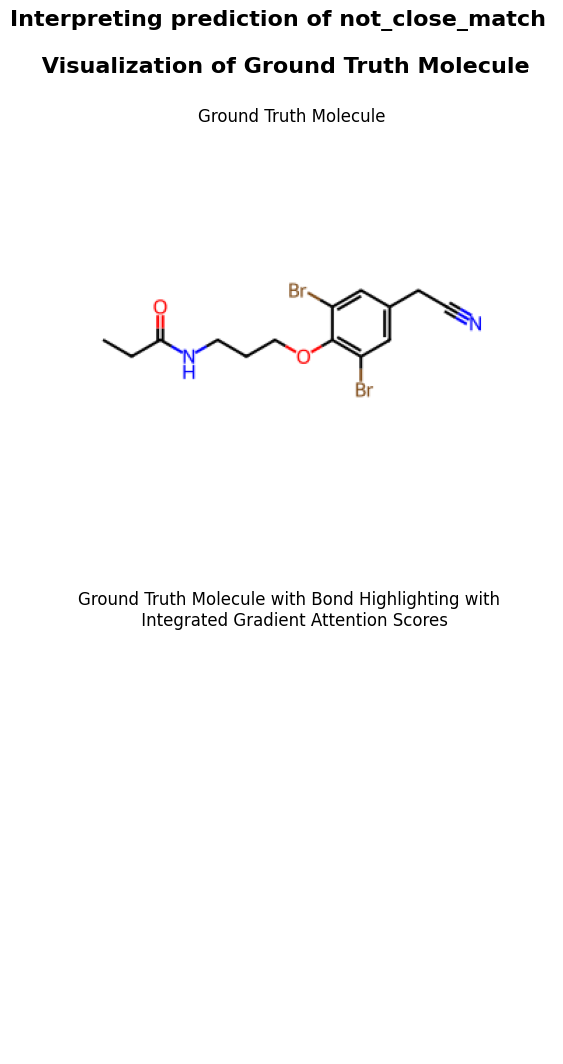

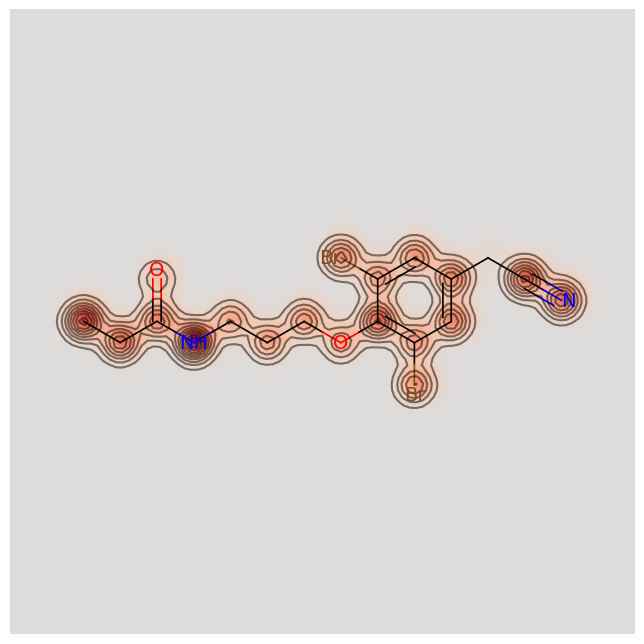

C:\Users\86136\AppData\Local\Temp\ipykernel_54224\2595035076.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0)  # Adjust padding to prevent overlap


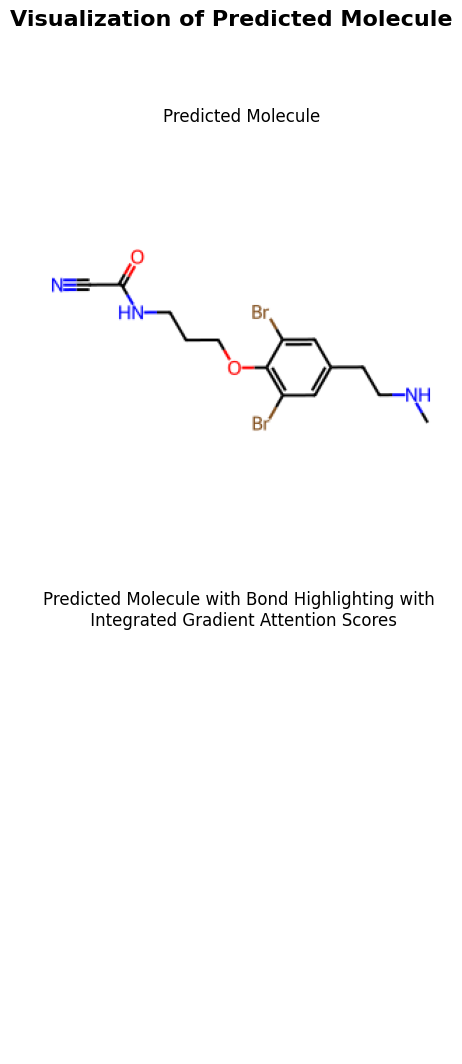

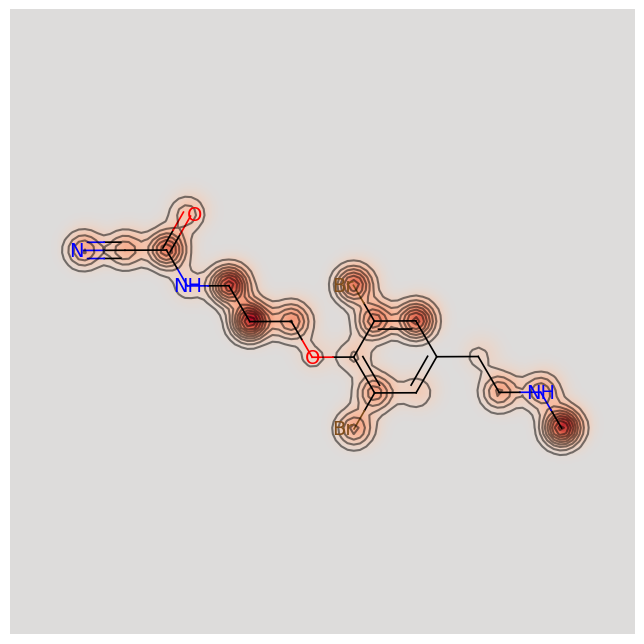

In [72]:
visualize_molecule(smile1, smile2, integrated_grads_gt, integrated_grads_pred)


C:\Users\86136\AppData\Local\Temp\ipykernel_54224\2595035076.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=3.0)  # Adjust padding to prevent overlap


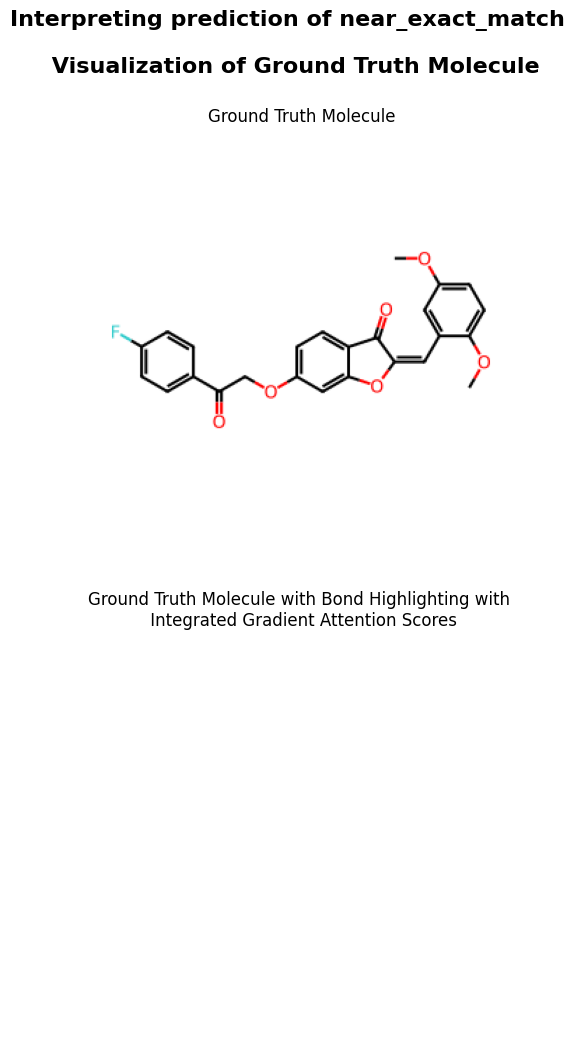

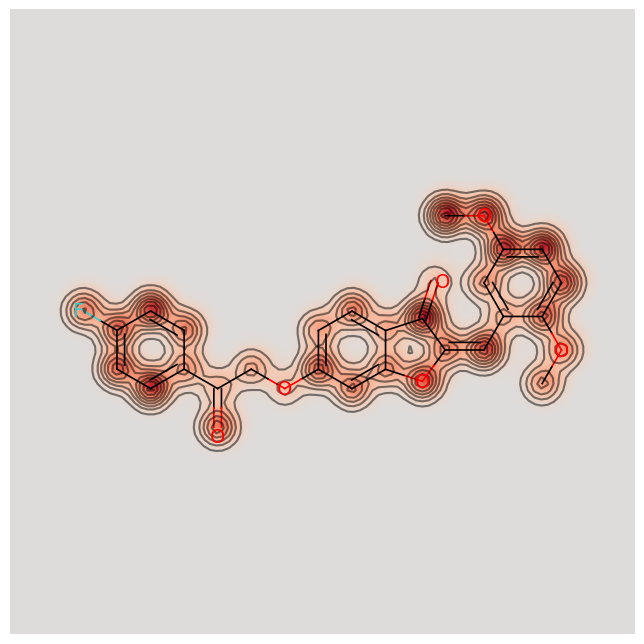

C:\Users\86136\AppData\Local\Temp\ipykernel_54224\2595035076.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0)  # Adjust padding to prevent overlap


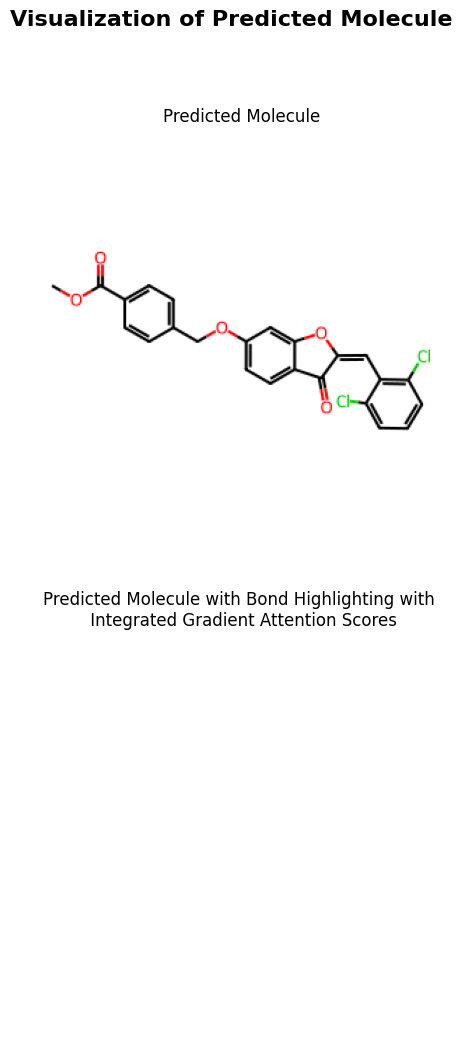

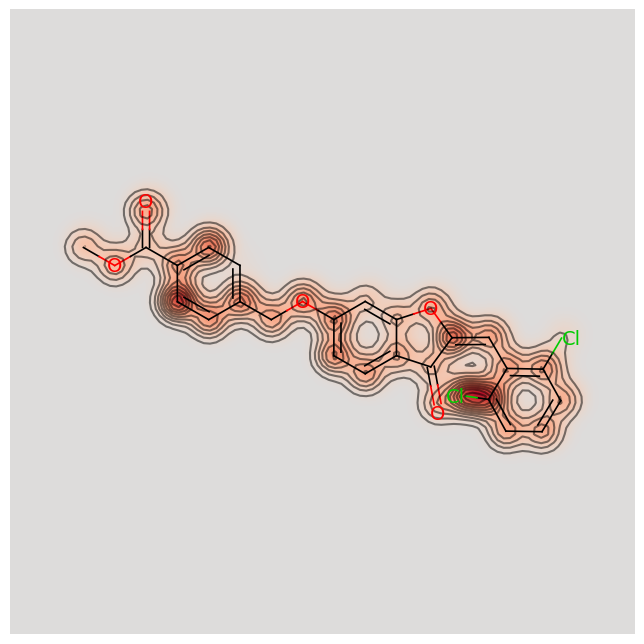

In [75]:
visualize_molecule(smile1, smile2, integrated_grads_gt, integrated_grads_pred)


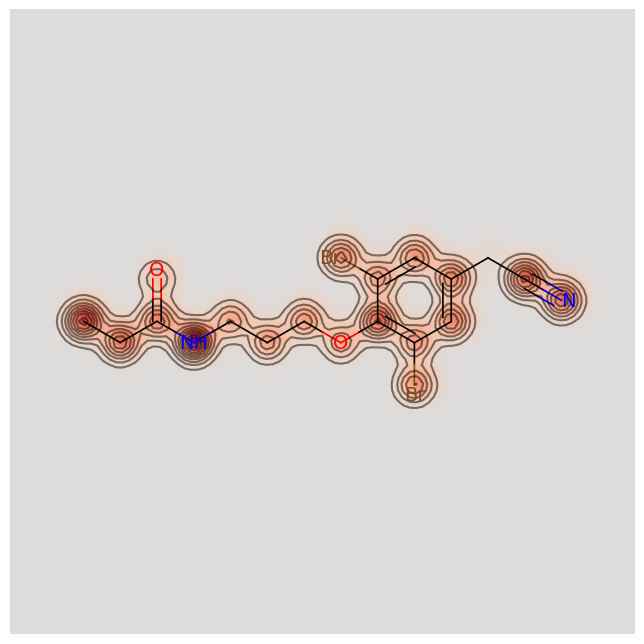

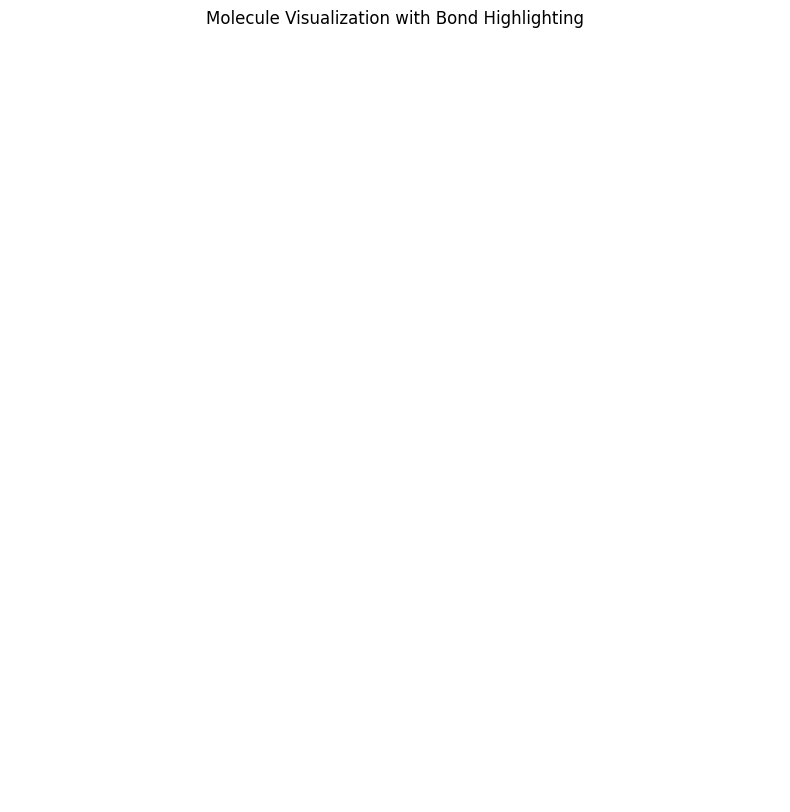

In [51]:
# Decode the tokens back to the SMILES string (assuming tokenizer.decode works)
decoded_smiles = smile1  # Replace with tokenizer.decode(smile_dict['input_ids'])

# Create a molecule object from the SMILES string
mol = Chem.MolFromSmiles(decoded_smiles)

# Generate 2D coordinates for the molecule
Chem.rdDepictor.SetPreferCoordGen(True)
Draw.rdMolDraw2D.PrepareMolForDrawing(mol)

# Normalize scores for mapping to [0, 1]
min_score = np.min(integrated_grads_gt[0])
max_score = np.max(integrated_grads_gt[0])

# Scale scores to [0, 1]
normed_scores = (integrated_grads_gt[0] - min_score) / (max_score - min_score)

# Molecule with bonds highlighted based on integrated gradients
draw2d_1 = Draw.rdMolDraw2D.MolDraw2DCairo(300, 300)

# Generate a similarity map based on the weights for bonds
SimilarityMaps.GetSimilarityMapFromWeights(mol, normed_scores.tolist(), 'coolwarm')

draw2d_1.FinishDrawing()

# Convert drawing text to an image using PIL
img_data = draw2d_1.GetDrawingText()
img = Image.open(io.BytesIO(img_data))
plt.figure(figsize=(10, 10))  # Adjust this size as needed
# Display the image using Matplotlib
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.title('Molecule Visualization with Bond Highlighting')
plt.show()

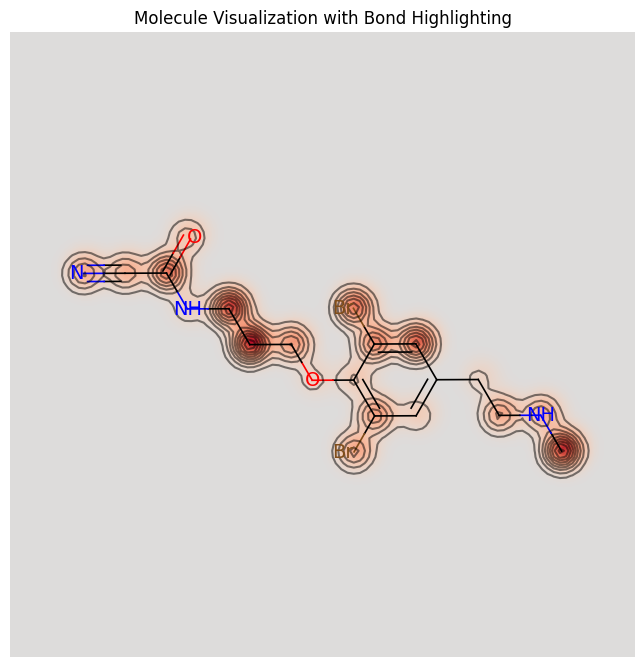

In [36]:
# Decode the tokens back to the SMILES string (assuming tokenizer.decode works)
decoded_smiles = smile2  # Replace with tokenizer.decode(smile_dict['input_ids'])

# Create a molecule object from the SMILES string
mol = Chem.MolFromSmiles(decoded_smiles)

# Generate 2D coordinates for the molecule
Chem.rdDepictor.SetPreferCoordGen(True)
Draw.rdMolDraw2D.PrepareMolForDrawing(mol)

# Normalize scores for mapping to [0, 1]
min_score = np.min(integrated_grads_pred[0])
max_score = np.max(integrated_grads_pred[0])

# Scale scores to [0, 1]
normed_scores = (integrated_grads_pred[0] - min_score) / (max_score - min_score)
# Create an empty drawing object for the similarity map
draw2d = Draw.rdMolDraw2D.MolDraw2DCairo(300, 300)

# Generate weights for each atom based on normalized scores
weights = normed_scores.tolist()

# Create a similarity map based on the weights
SimilarityMaps.GetSimilarityMapFromWeights(mol, weights, 'coolwarm')

# Finish drawing and display the image
draw2d.FinishDrawing()
img = draw2d.GetDrawingText()
# plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.title('Molecule Visualization with Bond Highlighting')
plt.show()

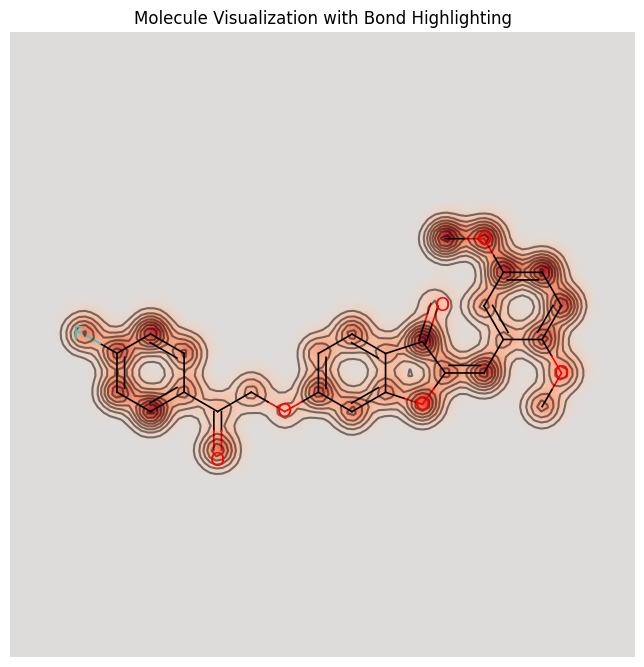

In [31]:
# Decode the tokens back to the SMILES string (assuming tokenizer.decode works)
decoded_smiles = smile1  # Replace with tokenizer.decode(smile_dict['input_ids'])

# Create a molecule object from the SMILES string
mol = Chem.MolFromSmiles(decoded_smiles)

# Generate 2D coordinates for the molecule
Chem.rdDepictor.SetPreferCoordGen(True)
Draw.rdMolDraw2D.PrepareMolForDrawing(mol)

# Normalize scores for mapping to [0, 1]
min_score = np.min(integrated_grads_gt[0])
max_score = np.max(integrated_grads_gt[0])

# Scale scores to [0, 1]
normed_scores = (integrated_grads_gt[0] - min_score) / (max_score - min_score)
# Create an empty drawing object for the similarity map
draw2d = Draw.rdMolDraw2D.MolDraw2DCairo(300, 300)

# Generate weights for each atom based on normalized scores
weights = normed_scores.tolist()

# Create a similarity map based on the weights
SimilarityMaps.GetSimilarityMapFromWeights(mol, weights, 'coolwarm')

# Finish drawing and display the image
draw2d.FinishDrawing()
img = draw2d.GetDrawingText()
# plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.title('Molecule Visualization with Bond Highlighting')
plt.show()


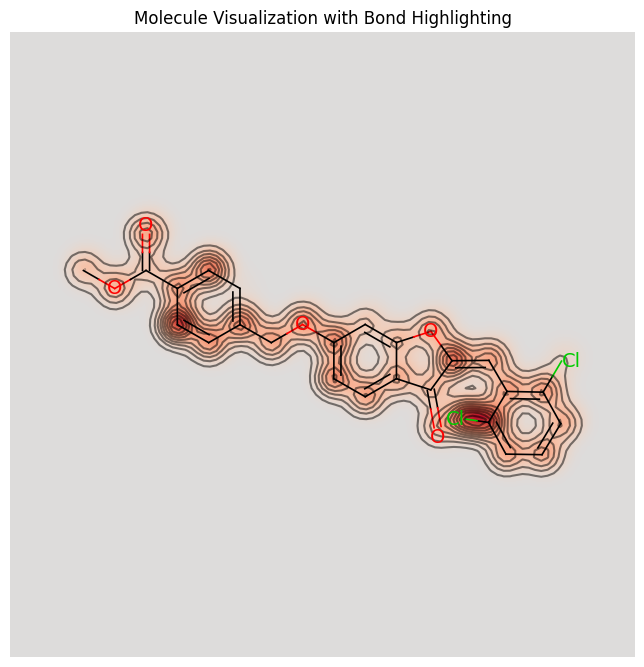

In [30]:
# Decode the tokens back to the SMILES string (assuming tokenizer.decode works)
decoded_smiles = smile2  # Replace with tokenizer.decode(smile_dict['input_ids'])

# Create a molecule object from the SMILES string
mol = Chem.MolFromSmiles(decoded_smiles)

# Generate 2D coordinates for the molecule
Chem.rdDepictor.SetPreferCoordGen(True)
Draw.rdMolDraw2D.PrepareMolForDrawing(mol)

# Normalize scores for mapping to [0, 1]
min_score = np.min(integrated_grads_pred[0])
max_score = np.max(integrated_grads_pred[0])

# Scale scores to [0, 1]
normed_scores = (integrated_grads_pred[0] - min_score) / (max_score - min_score)
# Create an empty drawing object for the similarity map
draw2d = Draw.rdMolDraw2D.MolDraw2DCairo(300, 300)

# Generate weights for each atom based on normalized scores
weights = normed_scores.tolist()

# Create a similarity map based on the weights
SimilarityMaps.GetSimilarityMapFromWeights(mol, weights, 'coolwarm')

# Finish drawing and display the image
draw2d.FinishDrawing()
img = draw2d.GetDrawingText()
# plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.title('Molecule Visualization with Bond Highlighting')
plt.show()

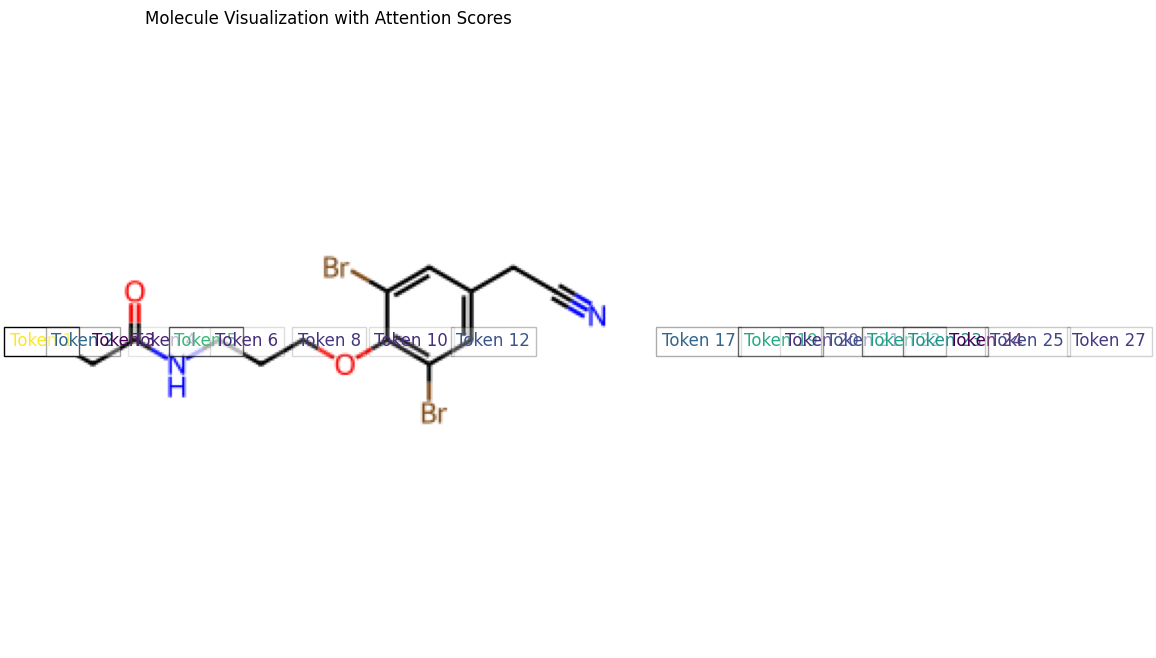

In [65]:
# Generate the molecule from SMILES
mol = Chem.MolFromSmiles(smile1)

# Compute the coordinates for the molecule
AllChem.Compute2DCoords(mol)

# Draw the molecule and get the image
img = Draw.MolToImage(mol)

# Convert the image to a numpy array for manipulation
img_array = np.array(img)

# Create a figure to display the molecule and attention scores
plt.figure(figsize=(8, 8))
plt.imshow(img_array)

# Normalize attention scores for visualization (scale to [0-1])
normalized_scores = integrated_grads_gt / np.max(integrated_grads_gt)

# Highlight regions based on attention scores
for i in range(len(normalized_scores[0])):
    if normalized_scores[0][i] > 0:
        # Get the coordinates of the token (this is a simplistic approach)
        # In practice you would map tokens to specific atom indices or coordinates
        # Here we assume a fixed position for demonstration purposes.
        plt.text(10 + i * 20, img_array.shape[0] // 2,
                 f'Token {i+1}', fontsize=12,
                 color=plt.cm.viridis(normalized_scores[0][i]), 
                 ha='center', va='center', 
                 bbox=dict(facecolor='white', alpha=normalized_scores[0][i]))

plt.axis('off') # Hide axes
plt.title('Molecule Visualization with Attention Scores')
plt.show()